#Python Implementation for paper :-
##Funnel-based Reachability Control of Unknown Nonlinear Systems using Gaussian Processes

#Imports

In [ ]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=6e69fe5664e48ae932d8f38023425b315a65413c5c7c6a11f3ab0611f94b80e1
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
import numpy as np
import matplotlib.pylab as plt
import math
from scipy import special
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# GP Jet Engine Example

##Generating Data

In [ ]:
def generate_noisy_points(n,noise_variance):
  np.random.seed()

  x1 = np.random.uniform(-5,5,n).reshape(-1,1)
  x2 = np.random.uniform(-5,3,n).reshape(-1,1)
  
  y1 = np.squeeze(np.array(-x2-(3/2)*x1**2-(1/2)*x1**3+noise_variance))
  y2 = np.squeeze(np.array(x1+noise_variance))

  return x1,x2,y1,y2

In [ ]:
# Define No of Points used as training data
n_training = 30
#math.exp(-1)*np.random.randn(1)
X1_train,X2_train,Y1_train,Y2_train = generate_noisy_points(n_training,math.exp(-1)*np.random.randn(1))

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(Y1_train.size), size=n_training, replace=False)
X1_train,Y1_train = X1_train[training_indices], Y1_train[training_indices]
X2_train,Y2_train = X2_train[training_indices], Y2_train[training_indices]

X_train = np.squeeze(np.array([X1_train,X2_train])).T
Y_train = np.squeeze(np.array([Y1_train,Y2_train])).T

print("Dimensions of X1_train are",X1_train.shape)
print("Dimensions of Y1_train are",Y1_train.shape)
print("Dimensions of X_train are",X_train.shape)
print("Dimensions of Y_train are",Y_train.shape)

Dimensions of X1_train are (30, 1)
Dimensions of Y1_train are (30,)
Dimensions of X_train are (30, 2)
Dimensions of Y_train are (30, 2)


In [ ]:
# Define No of Points used as testing data
n_test = 20

X1_test,X2_test,Y1_test,Y2_test = generate_noisy_points(n_test,math.exp(-5)*np.random.randn(1))

rng = np.random.RandomState(1)
test_indices = rng.choice(np.arange(Y1_test.size), size=n_test, replace=False)
X1_test,Y1_test = X1_test[test_indices], Y1_test[test_indices]
X2_test,Y2_test = X2_test[test_indices], Y2_test[test_indices]
X_test = np.squeeze(np.array([X1_test,X2_test])).T
Y_test = np.squeeze(np.array([Y1_test,Y2_test])).T
print(X_test.shape)
print(Y_test.shape)

(20, 2)
(20, 2)


## Learning Kernel and Model Fitting

In [ ]:
n_optimizer_1 = 9

# initializing the kernel function
kernel = 1*RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-3, 1e5),(1e-3, 1e5)])

gaussian_process = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer = n_optimizer_1)
gaussian_process.fit(X_train,Y1_train)
kernel_f1 = gaussian_process.kernel_

print(kernel_f1)

28.5**2 * RBF(length_scale=[0.154, 1.63e+04])


In [ ]:
# Prediction on the Test data points
mean_prediction_f1, std_prediction_f1 = gaussian_process.predict(X_test, return_std=True)

# Printing actuall predicted values for comparison
test = np.squeeze(np.array([Y1_test,mean_prediction_f1])).T
print(' Actual Value  -  Prediction')
print(test)
print("\n")
print('Standard Deviations')
print(std_prediction_f1)

# Accuracy in terms of RMS Error
print("\n")
print('RMS Error')
gaussian_process.score(X_test,Y1_test)

 Actual Value  -  Prediction
[[ 4.42151946e+00  1.81444170e+00]
 [-4.61434251e+00 -8.45580066e-01]
 [-7.84472245e+00 -9.58035507e-01]
 [-2.72082616e+01 -3.75231245e-01]
 [ 1.46169889e+00  9.03366143e-01]
 [ 1.42044777e+00  1.38698854e+00]
 [ 3.64517548e+00 -1.84569357e+01]
 [-3.06508180e+01 -3.52275764e+00]
 [ 2.36081570e+00  3.23866594e-01]
 [-2.97647237e+01 -3.37890825e+00]
 [-2.20497933e-01 -1.96764430e-02]
 [-4.27276218e+01 -4.94917765e+01]
 [-2.25095839e+01 -5.07837682e-01]
 [-7.87415470e+00 -7.58993874e+00]
 [ 6.24320566e+00  2.64094277e+01]
 [-6.60778218e+01 -6.55978980e+01]
 [ 2.72004521e+00  3.01809334e-01]
 [ 1.85771252e+00 -1.82326903e+01]
 [ 3.35030052e+00  1.86147541e+00]
 [-9.23823793e+01 -2.07482945e+01]]


Standard Deviations
[ 5.5588561  28.22325473 28.14205928 28.50046125 24.62513036 12.95202237
 16.33032987 27.71946158  2.16489488 27.77586774 21.96481663  8.5444485
 28.48891481 16.3388915  17.65643182  0.06232912 11.62094628 18.12192791
 26.19053396 18.86569372]


RM

0.3146582716587284

In [ ]:
n_optimizer_2 = 9

# initializing the kernel function
kernel2 = 1*RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-2, 1e4),(1e-2, 1e4)])

gaussian_process_2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=n_optimizer_2)
gaussian_process_2.fit(X_train,Y2_train)
kernel_f2 = gaussian_process_2.kernel_
print(kernel_f2)

316**2 * RBF(length_scale=[560, 1e+04])


In [ ]:
# Prediction on the Test data points
mean_prediction_f2, std_prediction_f2 = gaussian_process_2.predict(X_test, return_std=True)

# Printing actuall predicted values for comparison
test1 = np.squeeze(np.array([Y2_test,mean_prediction_f2])).T
print(' Actual Value - Prediction')
print(test1)
print("\n")
print('Standard Deviations')
print(std_prediction_f2)

# Accuracy in terms of RMS Error
print("\n")
print('RMS Error')
gaussian_process_2.score(X_test,Y2_test)

 Actual Value - Prediction
[[-0.05337045 -0.0414753 ]
 [ 1.77876685  1.79066133]
 [ 1.78861239  1.80050611]
 [ 2.88294486  2.89483833]
 [-0.7463746  -0.73448086]
 [-1.17260197 -1.16070795]
 [-3.67542315 -3.6635313 ]
 [ 3.14193289  3.15382671]
 [-1.68885878 -1.67696619]
 [ 3.13874794  3.15064383]
 [-0.19628131 -0.18438816]
 [ 3.75022387  3.76211691]
 [ 3.01401885  3.02591515]
 [ 2.18586232  2.19775677]
 [-4.08847577 -4.07658434]
 [ 4.21442099  4.22631454]
 [-1.6113984  -1.59950638]
 [-3.68997184 -3.67807961]
 [ 0.22610364  0.23799849]
 [ 4.90550843  4.91740131]]


Standard Deviations
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


RMS Error


0.9999805577818014

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.

##Plotting

<Figure size 432x288 with 0 Axes>

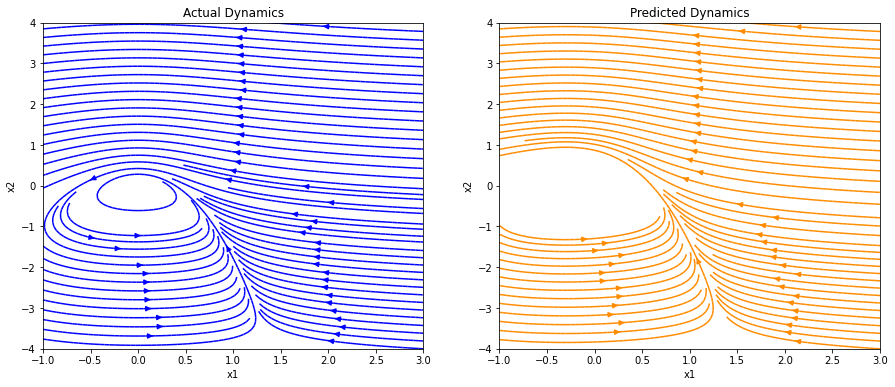

In [ ]:
# Original Func
x1,x2 = np.meshgrid(np.linspace(-1,3.1,100),np.linspace(-4,4.1,100))

noise_variance = 0 #math.exp(-4)*np.random.randn(1)
y1 = -x2-(3/2)*x1**2-(1/2)*x1**3 + noise_variance
y2 = x1+noise_variance

# Predicted Func
x1_test,x2_test = np.meshgrid(np.linspace(-1,3.1,100),np.linspace(-4,4.1,100))

X1_new = x1_test.reshape(10000,1)
X2_new = x2_test.reshape(10000,1)

X_new = np.squeeze(np.array([X1_new,X2_new])).T

mean_prediction_f1, std_prediction_f1 = gaussian_process.predict(X_new, return_std=True)
mean_prediction_f2, std_prediction_f2 = gaussian_process_2.predict(X_new, return_std=True)

y1_pred = mean_prediction_f1.reshape(100,100)
y2_pred = mean_prediction_f2.reshape(100,100)

x_st = np.linspace(-1,3,40)
x2_st = -np.linspace(-4,4,40)
x3_st = np.linspace(-4,4,40)
a = []
for i,j in zip(x_st,x3_st):
  temp = (i,j)
  a.append(temp)

for i,j in zip(x_st,x2_st):
  temp = (i,j)
  a.append(temp)
   
#plotting both the func side by side

plt.figure()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))

ax1.streamplot(x1,x2,y1,y2,start_points=a,density=2.5,color='b',minlength=0.3)
ax1.set_title('Actual Dynamics')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_xlim(-1,3)
ax1.set_ylim(-4,4)


ax2.streamplot(x1_test,x2_test,y1_pred,y2_pred,start_points=a,density=2.5,color='darkorange',minlength=0.3)
ax2.set_title('Predicted Dynamics')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_xlim(-1,3)
ax2.set_ylim(-4,4)

plt.show()

# GP Unknown Unstable Dynamics

## Generating Data

In [ ]:
def fun_2_noisy_points(n,noise_variance):
  np.random.seed()

  x1 = np.random.uniform(-5,5,n).reshape(-1,1)
  x2 = np.random.uniform(-5,5,n).reshape(-1,1)
  
  y1 = []
  y2 = []

  for i in range(len(x1)):
  
    y1 = np.append(y1,x1[i] + (math.cos(x1[i]) - 1)*x2[i] + noise_variance)    
    y2 = np.append(y2,-1/(1+math.exp(-2*x1[i])) + 0.5 + x2[i] + noise_variance)
  
  x1_dot = np.squeeze(np.array(y1))
  x2_dot = np.squeeze(np.array(y2))

  return x1,x2,x1_dot,x2_dot

In [ ]:
# Define No of Points used as training data
n_training = 50
#math.exp(-1)*np.random.randn(1)
X1_train,X2_train,X1_dot_train,X2_dot_train = fun_2_noisy_points(n_training,0)

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(X1_train.size), size=n_training, replace=False)
X1_train,X1_dot_train = X1_train[training_indices], X1_dot_train[training_indices]
X2_train,X2_dot_train = X2_train[training_indices], X2_dot_train[training_indices]

X_train = np.squeeze(np.array([X1_train,X2_train])).T
X_dot_train = np.squeeze(np.array([X1_dot_train,X2_dot_train])).T

X_train = np.load('X_train.npy')
X1_train = np.load('X1_train.npy')
X2_train = np.load('X2_train.npy')
X_dot_train = np.load('X_dot_train.npy')
X1_dot_train = np.load('X1_dot_train.npy')
X2_dot_train = np.load('X2_dot_train.npy')

'''
np.save('X_train.npy', X_train)
np.save('X1_train.npy', X1_train)
np.save('X2_train.npy', X2_train)
np.save('X_dot_train.npy', X_dot_train)
np.save('X1_dot_train.npy', X1_dot_train)
np.save('X2_dot_train.npy', X2_dot_train)
'''

print("Dimensions of X1_train are",X1_dot_train.shape)
print("Dimensions of Y1_train are",X2_dot_train.shape)
print("Dimensions of X_train are",X_train.shape)
print("Dimensions of Y_train are",X_dot_train.shape)

Dimensions of X1_train are (50,)
Dimensions of Y1_train are (50,)
Dimensions of X_train are (50, 2)
Dimensions of Y_train are (50, 2)


In [ ]:
# Define No of Points used as testing data
n_test = 10

X1_test,X2_test,X1_dot_test,X2_dot_test = fun_2_noisy_points(n_test,0)

rng = np.random.RandomState(1)
test_indices = rng.choice(np.arange(X1_dot_test.size), size=n_test, replace=False)
X1_test,X1_dot_test = X1_test[test_indices], X1_dot_test[test_indices]
X2_test,X2_dot_test = X2_test[test_indices], X2_dot_test[test_indices]
X_test = np.squeeze(np.array([X1_test,X2_test])).T
X_dot_test = np.squeeze(np.array([X1_dot_test,X2_dot_test])).T

print("Dimensions of X_test are",X_test.shape)
print("Dimensions of X_dot_test are",X_dot_test.shape)
print("Dimensions of X2_dot_test are",X2_dot_test.shape)

Dimensions of X_test are (10, 2)
Dimensions of X_dot_test are (10, 2)
Dimensions of X2_dot_test are (10,)


## Learning Kernel and Model Fitting

In [ ]:
n_optimizer_1 = 20

# initializing the kernel function

#kernel1 = 1*RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-2, 1e4),(1e-2, 1e4)])
kernel1 = 316**2*RBF(length_scale=[2.9,177])

gaussian_process_x1 = GaussianProcessRegressor(kernel=kernel1,n_restarts_optimizer =0)

# Fitting the Gaussian process regression model.
gaussian_process_x1.fit(X_train,X1_dot_train)
kernel_f1 = gaussian_process_x1.kernel_

print(kernel_f1)

316**2 * RBF(length_scale=[2.9, 177])


In [ ]:
# Prediction on the Test data points
mean_prediction_f1, std_prediction_f1 = gaussian_process_x1.predict(X_test, return_std=True)

# Printing actuall predicted values for comparison
test = np.squeeze(np.array([X1_dot_test,mean_prediction_f1])).T
print(' Actual Value  -  Prediction')
print(test)
print("\n")
print('Standard Deviations')
print(std_prediction_f1)

# Accuracy in terms of RMS Error
print("\n")
print('RMS Error')
gaussian_process_x1.score(X_test,X1_dot_test)

 Actual Value  -  Prediction
[[ 0.33565428  0.33566403]
 [-3.16698865 -3.16714942]
 [-0.12856087 -0.12861586]
 [ 0.31717506  0.31715345]
 [-0.19670588 -0.1967783 ]
 [-0.47866296 -0.47866356]
 [ 0.77530742  0.77527761]
 [-1.44746212 -1.44746137]
 [-5.54816181 -5.54796672]
 [ 1.47069228  1.47092927]]


Standard Deviations
[0.00000000e+00 8.23479963e-05 5.14630797e-05 7.31785816e-05
 6.19814942e-05 0.00000000e+00 3.81469727e-05 9.34406182e-06
 1.62337668e-04 1.15138155e-04]


RMS Error


0.9999999967274011

In [ ]:
n_optimizer_2 = 20

# initializing the kernel function
#kernel2 = 1*RBF(length_scale=[1.0,1.0], length_scale_bounds=[(1e-2, 1e4),(1e-2, 1e4)])
kernel2 = 25.3**2*RBF(length_scale=[1.67,50.5])

gaussian_process_x2 = GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=n_optimizer_2)

# Fitting the Gaussian process regression model.
gaussian_process_x2.fit(X_train,X2_dot_train)
kernel_f2 = gaussian_process_x2.kernel_

print(kernel_f2)

25.2**2 * RBF(length_scale=[1.72, 52.3])


In [ ]:
# Prediction on the Test data points
mean_prediction_f2, std_prediction_f2 = gaussian_process_x2.predict(X_test, return_std=True)

# Printing actuall predicted values for comparison
test1 = np.squeeze(np.array([X2_dot_test,mean_prediction_f2])).T
print(' Actual Value - Prediction')
print(test1)
print("\n")
print('Standard Deviations')
print(std_prediction_f2)

# Accuracy in terms of RMS Error
print("\n")
print('RMS Error')
gaussian_process_x2.score(X_test,X2_dot_test)

 Actual Value - Prediction
[[-1.79226676 -1.79219341]
 [ 3.01294103  3.01378715]
 [-2.7333852  -2.73128557]
 [ 0.86435442  0.86751386]
 [-1.15781907 -1.156936  ]
 [-0.59355034 -0.59353814]
 [-2.96348309 -2.9637586 ]
 [ 1.79305686  1.79304156]
 [ 4.41383755  4.40823158]
 [ 1.94723056  1.94802408]]


Standard Deviations
[4.12388337e-05 2.88468550e-04 6.12430367e-04 1.31436394e-03
 6.46486298e-04 2.47450461e-05 2.82631524e-04 3.12573941e-05
 1.34225955e-03 4.50888679e-04]


RMS Error


0.9999991529091772

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.

## Plotting

(100, 100)
(10000, 2)


<Figure size 432x288 with 0 Axes>

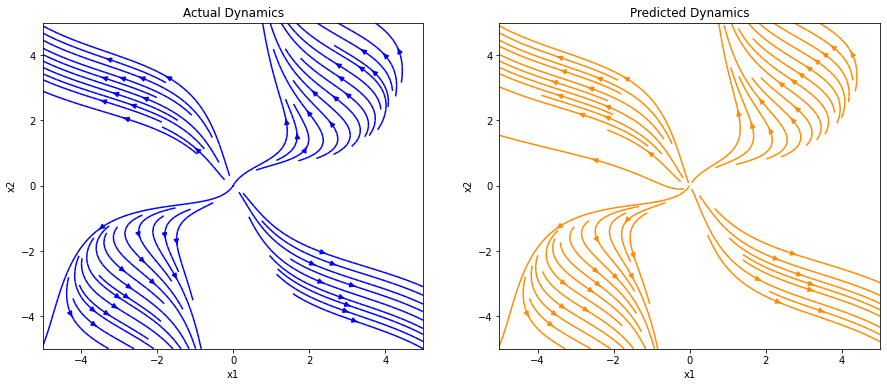

In [ ]:
# Original Func
x1,x2 = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))

noise_variance = 0 #math.exp(-4)*np.random.randn(1)
y1 = np.zeros([100,100])
y2 = np.zeros([100,100])

for i in range(x1.shape[0]):
  for j in range(x2.shape[1]):
    y1[j][i] = x1[j][i] + (math.cos(x1[j][i]) - 1)*x2[j][i]
    y2[j][i] = -1/(1+math.exp(-2*x1[j][i])) + 0.5 + x2[j][i]

x1_dot = np.squeeze(np.array(y1))
x2_dot = np.squeeze(np.array((y2)))

print(x1_dot.shape)

# Predicted Func
x1_test,x2_test = np.meshgrid(np.linspace(-5,5.1,100),np.linspace(-5,5.1,100))

X1_new = x1_test.reshape(10000,1)
X2_new = x2_test.reshape(10000,1)

X_new = np.squeeze(np.array([X1_new,X2_new])).T

mean_prediction_f1, std_prediction_f1 = gaussian_process_x1.predict(X_new, return_std=True)
mean_prediction_f2, std_prediction_f2 = gaussian_process_x2.predict(X_new, return_std=True)

y1_std = std_prediction_f1.reshape(100,100)
y2_std = std_prediction_f2.reshape(100,100)

y_new_std = np.squeeze(np.array([std_prediction_f1,std_prediction_f2])).T

y1_pred = mean_prediction_f1.reshape(100,100)
y2_pred = mean_prediction_f2.reshape(100,100)


print(y_new_std.shape)

x_st = np.linspace(-5,5,100)
x2_st = -np.linspace(-4.9,5,100)
x3_st = np.linspace(-4.9,5,100)
a = []

for i,j in zip(x_st,x3_st):
  temp = (i,j)
  a.append(temp)

for i,j in zip(x_st,x2_st):
  temp = (i,j)
  a.append(temp)
   
#plotting both the func side by side

plt.figure()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))

ax1.streamplot(x1,x2,x1_dot,x2_dot,start_points=a,density=2,color='b',minlength=0.2)
ax1.set_title('Actual Dynamics')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)

ax2.streamplot(x1_test,x2_test,y1_pred,y2_pred,start_points=a,density=2,color='darkorange',minlength=0.2)
ax2.set_title('Predicted Dynamics')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)

plt.show()

In [ ]:
####################
## Original Dynamics 
x1,x2 = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
np.savetxt('x1_org.mat',x1)
np.savetxt('x2_org.mat',x2)

## Predicted Dynamics
np.savetxt('y1_pred.mat',y1_pred)
np.savetxt('y2_pred.mat',y2_pred)

np.savetxt('y1_var.mat',std_prediction_f1)
np.savetxt('y2_var.mat',std_prediction_f2)
np.savetxt('y_var.mat',y_new_std)
#####################

# Monte Carlo Simulation

In [ ]:
# Original Function
x1,x2 = np.meshgrid(np.linspace(-5,5,1000),np.linspace(-5,5,1000))

noise_variance = 0
y1 = np.zeros([1000,1000])
y2 = np.zeros([1000,1000])

for i in range(x1.shape[0]):
  for j in range(x2.shape[1]):
    y1[j][i] = x1[j][i] + (math.cos(x1[j][i]) - 1)*x2[j][i]
    y2[j][i] = -1/(1+math.exp(-2*x1[j][i])) + 0.5 + x2[j][i]

x1_dot = np.squeeze(np.array(y1))
x2_dot = np.squeeze(np.array((y2)))

# Predicted Function
x1_test,x2_test = np.meshgrid(np.linspace(-5,5,1000),np.linspace(-5,5,1000))

X1_new = x1_test.reshape(1000000,)
X2_new = x2_test.reshape(1000000,)

X_new = np.squeeze(np.array([X1_new,X2_new])).T

mean_prediction_f1, std_prediction_f1 = gaussian_process_x1.predict(X_new, return_std=True)
mean_prediction_f2, std_prediction_f2 = gaussian_process_x2.predict(X_new, return_std=True)

y1_std = std_prediction_f1.reshape(1000,1000)
y2_std = std_prediction_f2.reshape(1000,1000)

y_new_std = np.squeeze(np.array([std_prediction_f1,std_prediction_f2])).T

y1_pred = mean_prediction_f1.reshape(1000,1000)
y2_pred = mean_prediction_f2.reshape(1000,1000)

In [ ]:
y1_actual = y1.reshape(1000000,)
y2_actual = y2.reshape(1000000,)

error1 = mean_prediction_f1 - y1_actual
error2 = mean_prediction_f2 - y2_actual

beta_sigma = 0.0441
s1 = sum(abs(error1)>beta_sigma)
s2 = sum(abs(error2)>beta_sigma)

n = len(y1_actual)
nf = (s1+s2)
ns = n - (s1+s2)

prob = nf/n
alpha = 1e-10;

z = math.sqrt(2)*special.erfinv(2*(1-alpha/2)-1)
prob_bound = [(ns/n)-(z/n)*math.sqrt(ns*nf/n), (ns/n)+(z/n)*math.sqrt(ns*nf/n)]

print('No of Train',n_training)
print('Kernel 1   ',gaussian_process_x1.kernel_)
print('Log Marg 1 ',gaussian_process_x1.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=True))

print('Kernel 2   ',gaussian_process_x2.kernel_)
print('Log Marg 2 ',gaussian_process_x2.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=True))

print('Max Std 1  ',max(std_prediction_f1))
print('Max Std 2  ',np.max(std_prediction_f2))
print('beta_sigma ',beta_sigma)
print('n,nf,ns    ',n,nf,ns)
print('probability',prob)
print('Bounds     ',prob_bound)

No of Train 50
Kernel 1    316**2 * RBF(length_scale=[2.9, 177])
Log Marg 1  123.61593266444291
Kernel 2    25.2**2 * RBF(length_scale=[1.72, 52.3])
Log Marg 2  73.66813292887332
Max Std 1   0.0022249465022125053
Max Std 2   0.014919386708096793
beta_sigma  0.0441
n,nf,ns     1000000 0 1000000
probability 0.0
Bounds      [1.0, 1.0]


# Calculating Lebnitz Constant

In [ ]:
from numpy import linalg as LA

x1,x2 = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))

y1 = np.zeros([100,100])
y2 = np.zeros([100,100])

for i in range(x1.shape[0]):
  for j in range(x2.shape[1]):
    y1[j][i] = x1[j][i] + (math.cos(x1[j][i]) - 1)*x2[j][i]
    y2[j][i] = -1/(1+math.exp(-2*x1[j][i])) + 0.5 + x2[j][i]

x_vec = np.array([x1,x2]).T

lib = np.zeros((100,100))
lib_2 = np.zeros((100,100))

# Function to calc lebnitz constant
def lebnitz_Li(x1,x2,y1,y2):
  numerator = abs(y1 - y2)
  a = x1 - x2
  denominator = math.sqrt(LA.norm(a, np.inf))

  Li = numerator/denominator
  
  return Li

for j in range(len(x1)):
  if j+1 == len(x1):
    break
  for i in range(len(x1)):
    if i+1 == len(x1):
      break
    
    lib[i][j] = lebnitz_Li(x_vec[j][i],x_vec[j][i+1],y1[j][i],y1[j][i+1])

    lib_2[i][j] = lebnitz_Li(x_vec[j][i],x_vec[j][i+1],y2[j][i],y2[j][i+1])
    
print(np.max(lib))
print(np.max(lib_2))

1.9052721075606034
0.15877545512542351


In [ ]:
Bi = np.array([0.23731,0.00017])
sig_1 = 0.022
sig_2 = 0.0616
y1T = X1_dot_train.T
y2T = X2_dot_train.T

y1 = X1_dot_train
y2 = X2_dot_train

_,cov_prediction_f1 = gaussian_process_x1.predict(X_train, return_cov=True)
_,cov_prediction_f2 = gaussian_process_x2.predict(X_train, return_cov=True)

print(Bi)

beta1 = np.sqrt(Bi[0] - y1T*cov_prediction_f1*y1 + 50)
beta2 = np.sqrt(Bi[1] - y2T*cov_prediction_f2*y2 + 50)

print(beta1[0][0])
print(beta2[0][0])

print(beta1[0][0]*sig_1)
print(beta2[0][0]*sig_2)


[2.3731e-01 1.7000e-04]
7.087828299173216
7.071079832657168
0.15593222258181075
0.4355785176916816


# Funnel-based Controller Simulation

In [ ]:
lower_x_ai = [-2, -2]
upper_x_ai = [-3, -3]

X_a = np.array([lower_x_ai, upper_x_ai])

lower_x_bi = [1, 1]
upper_x_bi = [3, 3]

X_b = np.array([lower_x_bi, upper_x_bi])

rho_inf = np.array([0.01, 0.01]).T
epsilon = np.array([0.1, 0.1]).T

beta_sigma = 0.3
epsilon_max = 0.1

n = np.array([2, 2])

t = np.arange(0, 20, 0.1, dtype=float).T

In [ ]:
def get_intersection(X_a, X_b):
    e_i = np.array([None, None])

    e_i[0] = range(max(X_a[:, 0][0], X_b[:, 0][0]), min(X_a[:, 0][1], X_b[:, 0][1])) or None
    e_i[1] = range(max(X_a[:, 1][0], X_b[:, 1][0]), min(X_a[:, 1][1], X_b[:, 1][1])) or None

    return e_i

def get_X_i(X_a, X_b):
    return np.array([np.minimum(X_a[0], X_b[0]), np.maximum(X_a[1], X_b[1])])

def get_rho_0(X_a, X_b, n):
    if get_intersection(X_a, X_b) is not None:
        return np.maximum(np.absolute(n - X_a[0]), np.absolute(n - X_a[1]))
    X_i = get_X_i(X_a, X_b)
    return np.maximum(np.absolute(n - X_i[0]), np.absolute(n - X_i[1]))

def cal_ci_di(X_a, X_b, n):
    in_section = get_intersection(X_a, X_b)
    X_i = get_X_i(X_a, X_b)
    rho_0 = get_rho_0(X_a, X_b, n)

    c = np.zeros(len(n))
    d = np.zeros(len(n))

    for i in range(len(n)):
        if in_section[i] !=  None:
            if abs(n[i] - X_a[0][i]) <= abs(n[i] - X_a[1][i]):
                c[i] = abs(n[i] - X_a[0][i]) / rho_0[i]
                d[i] = 1
            elif abs(n[i] - X_a[0][i]) > abs(n[i] - X_a[1][i]):
                c[i] = 1
                d[i] = abs(n[i] - X_a[1][i]) / rho_0[i]
        else:
            if abs(n[i] - X_i[0][i]) <= abs(n[i] - X_i[1][i]):
                c[i] = abs(n[i] - X_i[0][i]) / rho_0[i]
                d[i] = 1
            else:
                c[i] = 1
                d[i] = abs(n[i] - X_i[1][i]) / rho_0[i]

    return c, d

rho_0 = get_rho_0(X_a, X_b, n)


def get_rho_at_time(time):
    return rho_0 * np.exp(-1 * epsilon * time) + rho_inf

def get_x_hat(x_t, rho_t, n):
    return (x_t - n) / rho_t

def get_zi(x_hat, c_i, d_i):
    return np.log((d_i * (c_i + x_hat)) / (c_i * (d_i - x_hat)))

In [ ]:
def f_x(x):
    y1 = x[0] + (np.cos(x[0]) - 1) * x[1]
    y2 = -1 * (1 / (1 + np.exp(-2 * x[0]))) - 0.5 + x[1]

    return np.array([y1, y2])

In [ ]:
# Simulation of the controller 
x_t = np.array([-2.5, -2.5])

c_i, d_i = cal_ci_di(X_a, X_b ,n)
print(c_i,d_i)
x_t_arr = np.array([x_t])

def predict(x_t):
  X1_test, X2_test = np.meshgrid(x_t[0], x_t[1])
  X_test = np.hstack((X1_test.reshape(-1,1), X2_test.reshape(-1,1)))

  mu_f1 = gaussian_process_x1.predict(X_test, return_std=False)
  mu_f2 = gaussian_process_x2.predict(X_test, return_std=False)
  
  return np.array([mu_f1[0], mu_f2[0]])

for i in range(1, len(t)):

    rho_t = get_rho_at_time(t[i])
    x_hat = get_x_hat(x_t, rho_t, n)
    
    mu_p = predict(x_t)

    u = -1 * ( mu_p + np.sign(x_t) + f_x(x_t) + get_zi(x_hat, c_i, d_i) + epsilon_max * (x_t - n))

    x_curr = f_x(x_t)

    x_t = x_t + (x_curr + u) * (t[i] - t[i-1])
    x_t_arr = np.append(x_t_arr, [x_t], axis=0)

    #print(x_t)

[1. 1.] [0.2 0.2]


## Ode Solver

In [ ]:
def ode45_step(f, x, t, dt, *args):
    """
    One step of 4th Order Runge-Kutta method
    """
    k = dt
    k1 = k * f(t, x, *args)
    k2 = k * f(t + 0.5*k, x + 0.5*k1, *args)
    k3 = k * f(t + 0.5*k, x + 0.5*k2, *args)
    k4 = k * f(t + dt, x + k3, *args)
    return x + 1/6. * (k1 + 2*k2 + 2*k3 + k4)

def ode45(f, t, x0, *args):
    """
    4th Order Runge-Kutta method
    """
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i] 
        x[i+1] = ode45_step(f, x[i], t[i], dt, *args)
    return x

def f(t, x, u1, u2):
    y1 = x[0] + (math.cos(x[0]) - 1) * x[1]
    y2 = -1 * (1 / (1 + np.exp(-2 * x[0]))) - 0.5 + x[1]

    dydt = [y1 + u1, y2 + u2]

    return np.array(dydt)

In [ ]:
# Simulation of the controller 

x_t = np.array([-2.5, -2.5])

c_i, d_i = cal_ci_di(X_a, X_b ,n)

x_t_arr = np.array([x_t])

for i in range(0, len(t) - 1):

    rho_t = get_rho_at_time(t[i])
    x_hat = get_x_hat(x_t, rho_t, n)

    mu_p = predict(x_t)

    u = -1 * ((mu_p + np.sign(x_t)) * beta_sigma + get_zi(x_hat, c_i, d_i) + epsilon_max * (x_t - n))

    dt = t[i + 1] - t[i]
    x_t = ode45_step(f, x_t, t[i], dt, u[0], u[1])
    print(x_t)
    
    x_t_arr = np.append(x_t_arr, [x_t], axis=0)
    

np.savetxt('x_dot_.mat',x_t_arr)


[-1.92869806 -2.25509583]
[-1.50178833 -2.03565684]
[-1.15708815 -1.83249862]
[-0.86325906 -1.64220943]
[-0.60047756 -1.46347008]
[-0.35555888 -1.2958272 ]
[-0.11954222 -1.13912509]
[ 0.11363342 -0.99306352]
[ 0.2840242 -0.8553467]
[ 0.45630427 -0.72443387]
[ 0.63047579 -0.59939704]
[ 0.80567261 -0.47923876]
[ 0.98020011 -0.36298981]
[ 1.15163553 -0.24979325]
[ 1.31701294 -0.13895205]
[ 1.47308954 -0.02994061]
[1.6166593 0.0776076]
[1.74847697 0.12081406]
[1.86846998 0.16421417]
[1.97522644 0.20789139]
[2.06764496 0.25188577]
[2.14503644 0.29620637]
[2.2072176  0.34084022]
[2.25458106 0.38575864]
[2.28810325 0.43092153]
[2.30926367 0.47628033]
[2.31987437 0.52178009]
[2.32185627 0.56736098]
[2.31703523 0.61295942]
[2.3070048  0.65850896]
[2.29307232 0.70394102]
[2.27626542 0.74918546]
[2.25737367 0.79417109]
[2.23699758 0.83882603]
[2.21559534 0.88307814]
[2.19352088 0.92685528]
[2.17105198 0.97008569]
[2.14841077 1.01269827]
[2.12577954 1.05462293]
[2.10330956 1.09579096]
[2.08112885 

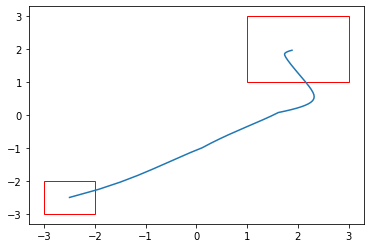

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.plot(x_t_arr[:, 0], x_t_arr[:, 1])

ax.add_patch(
    patches.Rectangle(
        xy=(-3, -3),  # point of origin.
        width=1, height=1, linewidth=1,
        color='red', fill=False))

ax.add_patch(
    patches.Rectangle(
        xy=(1, 1),  # point of origin.
        width=2, height=2, linewidth=1,
        color='red', fill=False))

plt.show()